### IMPORTING PACKAGES

In [19]:
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql import DataFrame
import pandas as pd
from pyspark.sql.functions import (
    min, max, year, month, col, isnan, isnull, when, count, countDistinct, 
    round, desc, sum as sum_, mean, stddev, variance, skewness, kurtosis, 
    explode, split, regexp_replace, to_timestamp, to_date, lit, datediff, current_date
)
from pyspark.sql.types import StringType
import matplotlib.pyplot as plt
from functools import reduce
from pyspark.sql import functions as F
from pyspark.ml import Pipeline
from pyspark.sql.window import Window
from pyspark.sql.functions import create_map, lit
from itertools import chain
from pyspark.sql.functions import avg as F_avg
from pyspark.sql.functions import sum as F_sum
from pyspark.sql.functions import count as F_count
from pyspark.sql.functions import col, round as F_round
from pyspark.sql.functions import log1p 
import seaborn as sns
from pyspark.ml.stat import Correlation
import numpy as np
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import pylab as pl
from pyspark.ml.linalg import Vectors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler, PCA



import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# Changing the directory in the Colab notebook to a specific location within the Google Drive
%cd C:\Users\june3\OneDrive\Desktop\my_output_result\

C:\Users\june3\OneDrive\Desktop\my_output_result


### CREATE SPARK SESSION

In [3]:
# Step 1: Create a SparkSession
spark = SparkSession.builder \
    .appName("SDWA DATA ANALYSIS 1") \
    .getOrCreate()

### LOADING .CSV FILES AND READING INTO SPARK DATAFRAMES

In [4]:
# Step 2: Read all CSV files into a list of Spark DataFrames
df = spark.read.csv("df_pandas.csv", header=True, inferSchema=True)

In [5]:
def get_missing_values(df, dataframe_name):
    # Compute missing values for each column
    missing_df = df.select([
        count(when(isnull(c) | isnan(c), c)).alias(c) for c in df.columns
    ])
    
    # Convert to Pandas for better formatting
    missing = missing_df.toPandas().transpose().reset_index()
    missing.columns = ['Column', 'Missing_Count']
    
    # Display the missing values
    print(f"--- Missing Values in {dataframe_name} ---")
    print(missing.to_markdown(index=False))
    print("\n")

In [6]:
def get_summary_statistics(df, dataframe_name):
    # Compute summary statistics
    summary = df.describe().toPandas().set_index('summary').transpose()
    
    # Rename the index to the dataframe name for clarity
    summary.index.name = 'Column'
    
    # Display the summary statistics
    print(f"--- Summary Statistics for {dataframe_name} ---")
    print(summary.to_markdown())
    print("\n")

### DATAFRAME 1

In [7]:
print(f" Dataframe 1: rows: {df.count()}, columns: {len(df.columns)} ")

 Dataframe 1: rows: 43073, columns: 29 


In [8]:
cat_vars = ["PWS_ACTIVITY_CODE", 
            "IS_SCHOOL_OR_DAYCARE_IND",
            "SOURCE_WATER_PROTECTION_CODE", 
            "OUTSTANDING_PERFORMER",
            "MANAGEMENT_OPS_EVAL_CODE",
            "SOURCE_WATER_EVAL_CODE",
            "SECURITY_EVAL_CODE",
            "PUMPS_EVAL_CODE",
            "OTHER_EVAL_CODE",
            "COMPLIANCE_EVAL_CODE",
            "DATA_VERIFICATION_EVAL_CODE",
            "TREATMENT_EVAL_CODE",
            "FINISHED_WATER_STOR_EVAL_CODE",
            "DISTRIBUTION_EVAL_CODE",
            "FINANCIAL_EVAL_CODE",
            "VIOLATION_CATEGORY_CODE",
            "IS_HEALTH_BASED_IND",
            "IS_MAJOR_VIOL_IND",
            "VIOLATION_STATUS",
            "ENF_ACTION_CATEGORY",
           "COMPLIANCE_STATUS"]

In [9]:
num_vars = ["TOTAL_POPULATION_SERVED_COUNT_LOG",
            "TOTAL_SERVICE_CONNECTIONS_COUNT_LOG",
            "VIOL_MEASURE_LOG",
            "TOTAL_VIOLATIONS_LOG",
            "AVG_VIOLATION_DURATION_DAYS_LOG",
            "OPEN_VIOLATIONS_COUNT_LOG",
            "TOTAL_LATE_COMPLIANT_ACTIONS_LOG"
           ]

In [10]:
get_missing_values(df,  "DATAFRAME")

--- Missing Values in DATAFRAME ---
| Column                              |   Missing_Count |
|:------------------------------------|----------------:|
| PWSID                               |               0 |
| PWS_ACTIVITY_CODE                   |               0 |
| IS_SCHOOL_OR_DAYCARE_IND            |               0 |
| SOURCE_WATER_PROTECTION_CODE        |               0 |
| OUTSTANDING_PERFORMER               |               0 |
| MANAGEMENT_OPS_EVAL_CODE            |               0 |
| SOURCE_WATER_EVAL_CODE              |               0 |
| SECURITY_EVAL_CODE                  |               0 |
| PUMPS_EVAL_CODE                     |               0 |
| OTHER_EVAL_CODE                     |               0 |
| COMPLIANCE_EVAL_CODE                |               0 |
| DATA_VERIFICATION_EVAL_CODE         |               0 |
| TREATMENT_EVAL_CODE                 |               0 |
| FINISHED_WATER_STOR_EVAL_CODE       |               0 |
| DISTRIBUTION_EVAL_CODE            

In [11]:
# Pipeline stages
stages = []

# Step 1: Process categorical variables
for col in cat_vars:
    # StringIndexer for categorical variable
    indexer = StringIndexer(inputCol=col, outputCol=f"{col}_indexed")
    stages.append(indexer)

    # OneHotEncoder for indexed variable
    encoder = OneHotEncoder(inputCol=f"{col}_indexed", outputCol=f"{col}_encoded")
    stages.append(encoder)

# Step 2: Combine all encoded categorical and numerical columns using VectorAssembler
# Collect encoded categorical columns and add numerical columns
assembled_input_cols = [f"{col}_encoded" for col in cat_vars] + num_vars

assembler = VectorAssembler(inputCols=assembled_input_cols, outputCol="features")
stages.append(assembler)

# Step 3: Create the pipeline
pipeline = Pipeline(stages=stages)

# Fit and transform the data
final_df = pipeline.fit(df).transform(df)

# final_df will have a "features" column with all categorical and numerical variables combined


In [12]:
final_df.printSchema()

root
 |-- PWSID: string (nullable = true)
 |-- PWS_ACTIVITY_CODE: string (nullable = true)
 |-- IS_SCHOOL_OR_DAYCARE_IND: string (nullable = true)
 |-- SOURCE_WATER_PROTECTION_CODE: string (nullable = true)
 |-- OUTSTANDING_PERFORMER: string (nullable = true)
 |-- MANAGEMENT_OPS_EVAL_CODE: string (nullable = true)
 |-- SOURCE_WATER_EVAL_CODE: string (nullable = true)
 |-- SECURITY_EVAL_CODE: string (nullable = true)
 |-- PUMPS_EVAL_CODE: string (nullable = true)
 |-- OTHER_EVAL_CODE: string (nullable = true)
 |-- COMPLIANCE_EVAL_CODE: string (nullable = true)
 |-- DATA_VERIFICATION_EVAL_CODE: string (nullable = true)
 |-- TREATMENT_EVAL_CODE: string (nullable = true)
 |-- FINISHED_WATER_STOR_EVAL_CODE: string (nullable = true)
 |-- DISTRIBUTION_EVAL_CODE: string (nullable = true)
 |-- FINANCIAL_EVAL_CODE: string (nullable = true)
 |-- VIOLATION_CATEGORY_CODE: string (nullable = true)
 |-- IS_HEALTH_BASED_IND: string (nullable = true)
 |-- IS_MAJOR_VIOL_IND: string (nullable = true)
 |-

In [13]:
# Standardize the feature vector
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(final_df)
scaled_data = scaler_model.transform(final_df)

In [14]:
scaled_data.cache()

DataFrame[PWSID: string, PWS_ACTIVITY_CODE: string, IS_SCHOOL_OR_DAYCARE_IND: string, SOURCE_WATER_PROTECTION_CODE: string, OUTSTANDING_PERFORMER: string, MANAGEMENT_OPS_EVAL_CODE: string, SOURCE_WATER_EVAL_CODE: string, SECURITY_EVAL_CODE: string, PUMPS_EVAL_CODE: string, OTHER_EVAL_CODE: string, COMPLIANCE_EVAL_CODE: string, DATA_VERIFICATION_EVAL_CODE: string, TREATMENT_EVAL_CODE: string, FINISHED_WATER_STOR_EVAL_CODE: string, DISTRIBUTION_EVAL_CODE: string, FINANCIAL_EVAL_CODE: string, VIOLATION_CATEGORY_CODE: string, IS_HEALTH_BASED_IND: string, IS_MAJOR_VIOL_IND: string, VIOLATION_STATUS: string, ENF_ACTION_CATEGORY: string, COMPLIANCE_STATUS: string, TOTAL_POPULATION_SERVED_COUNT_LOG: double, TOTAL_SERVICE_CONNECTIONS_COUNT_LOG: double, VIOL_MEASURE_LOG: double, TOTAL_VIOLATIONS_LOG: double, AVG_VIOLATION_DURATION_DAYS_LOG: double, OPEN_VIOLATIONS_COUNT_LOG: double, TOTAL_LATE_COMPLIANT_ACTIONS_LOG: double, PWS_ACTIVITY_CODE_indexed: double, PWS_ACTIVITY_CODE_encoded: vector, IS

In [15]:
# Extract 'features' column from PySpark DataFrame and convert it to Pandas
pandas_df = scaled_data.select('scaled_features').toPandas()

# Convert the PySpark vector to a NumPy array that can be used in sklearn
X = np.array(pandas_df['scaled_features'].tolist())

In [20]:
# Define range of number of clusters for Gaussian Mixture Model
n_components_values = np.arange(2, 11, 1)  # Trying 2 to 10 clusters
results = []

for n_components in n_components_values:
    # Initialize and fit GaussianMixture with the current number of components (clusters)
    gmm = GaussianMixture(n_components=n_components)
    labels = gmm.fit_predict(X)
    
    # Check if there are at least 2 clusters
    unique_labels = set(labels)
    num_clusters = len(unique_labels)
    
    if num_clusters > 1:
        # Filter out noise points (if any, or just calculate metrics for valid clusters)
        clustered_points = X
        valid_labels = labels
        
        # Calculate metrics
        silhouette = silhouette_score(clustered_points, valid_labels)
        davies_bouldin = davies_bouldin_score(clustered_points, valid_labels)
        calinski_harabasz = calinski_harabasz_score(clustered_points, valid_labels)
        
        # Store results
        results.append([n_components, num_clusters, silhouette, davies_bouldin, calinski_harabasz])
    else:
        # Store results for the case where there are insufficient clusters
        results.append([n_components, num_clusters, None, None, None])

# Create a DataFrame for better visualization
df_results = pd.DataFrame(results, columns=["Number of Components", "Num Clusters", "Silhouette Score", "Davies-Bouldin Score", "Calinski-Harabasz Score"])

In [22]:
df_results

,Number of Components,Num Clusters,Silhouette Score,Davies-Bouldin Score,Calinski-Harabasz Score
0,2,2,0.085948,3.359155,3218.931589
1,3,3,0.121757,3.851437,3793.517552
2,4,4,0.101578,4.053454,3086.613598
3,5,5,0.212190,2.390156,3714.993102
4,6,6,0.091839,3.369352,2510.114262
5,7,7,0.086963,4.519894,1962.749526
6,8,8,0.044361,3.779615,1865.821377
7,9,9,0.033040,3.753970,1756.404109
8,10,10,0.071130,3.195556,2460.599126


In [16]:
df = scaled_data.toPandas()

In [69]:
from sklearn.mixture import GaussianMixture

# Initialize and fit Gaussian Mixture Model
n_components = 6
gmm = GaussianMixture(n_components=n_components, random_state=0)
gmm.fit(X)

# Predict clusters
labels = gmm.predict(X)
df['cluster'] = labels

In [70]:
# Model evaluation
# print("Means:", gmm.means_)
# print("Covariances:", gmm.covariances_)
print("BIC:", gmm.bic(X))
print("AIC:", gmm.aic(X))

BIC: -11187231.194414672
AIC: -11364259.888737725


In [71]:
# Count the number of data points in each cluster, including noise (-1)
cluster_counts = pd.Series(labels).value_counts()

# Calculate the percentage distribution of samples in each cluster
percentage_distribution = (cluster_counts / len(labels)) * 100

# Create a DataFrame with the counts and percentage distribution
cluster_df = pd.DataFrame({
    'Cluster': cluster_counts.index,
    'Count': cluster_counts.values,
    'Percentage': percentage_distribution.values
})

In [72]:
print(cluster_df)

   Cluster  Count  Percentage
0        2  15535   36.066678
1        3   7621   17.693218
2        1   7427   17.242820
3        5   7178   16.664732
4        4   3638    8.446126
5        0   1674    3.886425


In [73]:
# Calculate the Silhouette Score
silhouette_avg = silhouette_score(X, labels)
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.13177563144775442


In [74]:
# Calculate the Davies-Bouldin Index
dbi = davies_bouldin_score(X, labels)
print(f'Davies-Bouldin Index: {dbi}')

Davies-Bouldin Index: 4.877368549128765


In [75]:
from sklearn.metrics import calinski_harabasz_score
# Calculate Calinski-Harabasz Score
ch_score = calinski_harabasz_score(X, labels)
print("Calinski-Harabasz Score:", ch_score)

Calinski-Harabasz Score: 2708.269285746137


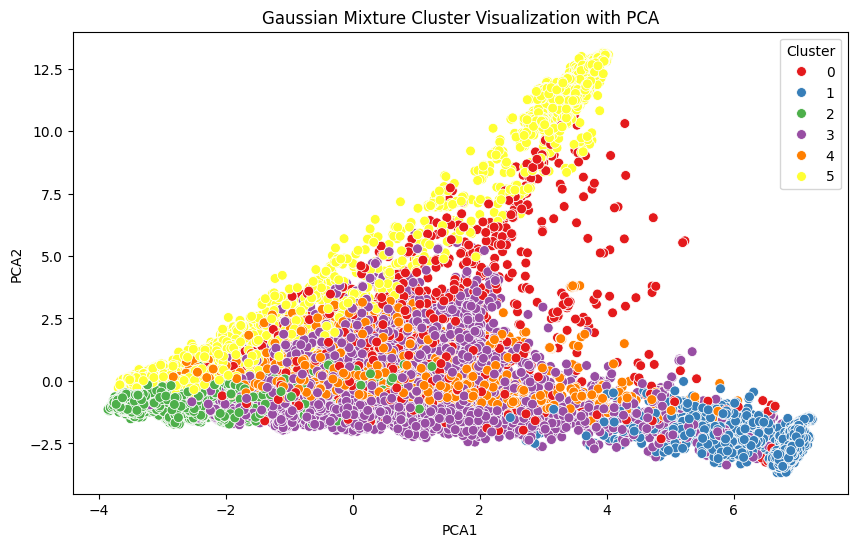

In [76]:
from sklearn.decomposition import PCA

# Reduce the data to 2 dimensions using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create a DataFrame with the PCA results and cluster labels
visual_df = df.copy()
visual_df['PCA1'] = X_pca[:, 0]
visual_df['PCA2'] = X_pca[:, 1]

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=visual_df, x='PCA1', y='PCA2', hue='cluster', palette='Set1', s=50)
plt.title("Gaussian Mixture Cluster Visualization with PCA")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend(title='Cluster')
plt.show()

In [112]:
# # Step 1: Expand the 'features' column into separate columns
# features_expanded = df_pandas['pca_features'].apply(pd.Series)

# # Step 2: Rename the new columns for clarity (optional)
# features_expanded.columns = [f'feature_{i+1}' for i in range(features_expanded.shape[1])]

# # Step 3: Concatenate the new columns back to the original DataFrame
# df_final = pd.concat([df_pandas, features_expanded], axis=1)

# # Step 4: Drop the original 'features' column if no longer needed
# df_final = df_final.drop('pca_features', axis=1)

In [113]:
# print(df_final.dtypes)

PWSID                            object
PWS_ACTIVITY_CODE                object
IS_SCHOOL_OR_DAYCARE_IND         object
SOURCE_WATER_PROTECTION_CODE     object
OUTSTANDING_PERFORMER            object
                                 ...   
features                         object
scaled_features                  object
prediction                        int32
feature_1                       float64
feature_2                       float64
Length: 73, dtype: object


In [114]:
# # Assuming df is your DataFrame and you want to drop columns by name
# columns_to_drop = ['features', 'scaled_features']
# df = df_final.drop(columns=columns_to_drop)

In [77]:
# Set index=True if you want to save the DataFrame index
df.to_csv('C:/Users/june3/OneDrive/Desktop/my_output_result/gmm_k6.csv', index=False)

In [23]:
spark.stop()